In [111]:
%reload_ext autoreload
%autoreload 2
import chess.pgn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from chess_dataset import *
from parse_game import *
import helper

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [112]:
train_chess_pair_dataset = ChessPairDataset()
test_chess_pair_dataset = ChessPairDataset(train=False)
train_chess_dataset = ChessDataset("dataset/games.npy")
test_chess_dataset = ChessDataset("dataset/games.npy", train=False)

In [113]:
len(train_chess_pair_dataset), len(test_chess_pair_dataset)

(800000, 200000)

In [114]:
len(train_chess_dataset), len(test_chess_dataset)

(386672, 96669)

In [115]:
chess_trainloader = DataLoader(train_chess_dataset, batch_size=128, shuffle=True)
chess_testloader = DataLoader(test_chess_dataset, batch_size=128, shuffle=False)
chess_pair_trainloader = DataLoader(train_chess_pair_dataset, batch_size=128, shuffle=True)
chess_pair_testloader = DataLoader(test_chess_pair_dataset, batch_size=128, shuffle=False)

Epoch: 0 | Loss: 25.359: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 3021/3021 [00:55<00:00, 54.58it/s]
Loss: 42.691280: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 756/756 [00:06<00:00, 116.25it/s]
Epoch: 1 | Loss: 21.367: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 3021/3021 [00:54<00:00, 54.94it/s]
Loss: 43.276745: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 756/756 [00:06<00:00, 121.93it/s]
Epoch: 2 | Loss: 22.072: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 3021/3021 [00:55<00:00, 54.26it/s]
Loss: 45.146606: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 756/756 [00:06<00:00, 114.63it/s]


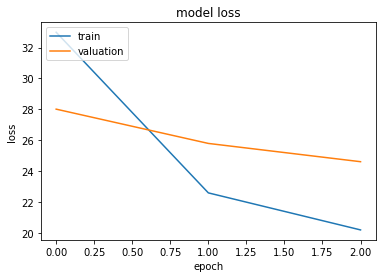

In [73]:
def freeze(layer):
  layer.weight.requires_grad = False
  layer.bias.requires_grad = False

def unfreeze(layer):
  layer.weight.requires_grad = True
  layer.bias.requires_grad = True
  
# Dense encoding layers
en1 = nn.Linear(773, 600)
bne1 = nn.BatchNorm1d(600)
en2 = nn.Linear(600, 400)
bne2 = nn.BatchNorm1d(400)
en3 = nn.Linear(400, 200)
bne3 = nn.BatchNorm1d(200)
en4 = nn.Linear(200, 100)
bne4 = nn.BatchNorm1d(100)

# Dense decoding layers
de1 = nn.Linear(600, 773)
bnd1 = nn.BatchNorm1d(773)
de2 = nn.Linear(400, 600)
bnd2 = nn.BatchNorm1d(600)
de3 = nn.Linear(200, 400)
bnd3 = nn.BatchNorm1d(400)
de4 = nn.Linear(100, 200)
bnd4 = nn.BatchNorm1d(200)

# # Autoencoder train
# # 773 - 600 - 773
# ae1 = nn.Sequential(en1, nn.Dropout(0.3), nn.ReLU(), bne1,
#                     de1)
# his = helper.train_autoencoder(ae1, chess_trainloader, chess_testloader, 5, 2, 0.005)
# helper.plot(his)

# # * means freeze
# # 773 *- 600 - 400 - 600 *- 773
# freeze(en1)
# freeze(de1)
# ae2 = nn.Sequential(en1, nn.Dropout(0.3), nn.ReLU(), bne1, en2, nn.ReLU(), bne2,
#                     de2, nn.ReLU(), bnd2, de1)
# his = helper.train_autoencoder(ae2, chess_trainloader, chess_testloader, 5, 2, 0.005)
# helper.plot(his)

# # 773 *- 600 *- 400 - 200 - 400 *- 600 *- 773
# freeze(en2)
# freeze(de2)
# ae3 = nn.Sequential(en1, nn.Dropout(0.3), nn.ReLU(), bne1, en2, nn.ReLU(), bne2, en3, nn.ReLU(), bne3,
#                     de3, nn.ReLU(), bnd3, de2, nn.ReLU(), bnd2, de1)
# his = helper.train_autoencoder(ae3, chess_trainloader, chess_testloader, 5, 2, 0.005)
# helper.plot(his)
# # 773 *- 600 *- 400 *- 200 - 100 - 200 *- 400 *- 600 *- 773
# freeze(en3)
# freeze(de3)
ae4 = nn.Sequential(en1, nn.Dropout(0.3), nn.LeakyReLU(), bne1, en2, nn.LeakyReLU(), bne2, en3, nn.LeakyReLU(), bne3, en4, nn.LeakyReLU(), bne4, 
                    de4, nn.LeakyReLU(), bnd4, de3, nn.LeakyReLU(), bnd3, de2, nn.LeakyReLU(), bnd2, de1)
his = helper.train_autoencoder(ae4, chess_trainloader, chess_testloader, 3, 2, 5e-3)
helper.plot(his)

# unfreeze(en1)
# unfreeze(en1)
# unfreeze(en3)

pos2vec = nn.Sequential(en1, nn.Dropout(0.3), nn.LeakyReLU(), bne1, en2, nn.Dropout(0.3), nn.LeakyReLU(), bne2, en3, nn.Dropout(0.3), nn.LeakyReLU(), bne3, en4, nn.Dropout(0.3), nn.LeakyReLU(), bne4)
torch.save(pos2vec.state_dict(), "model/checkpoints/pos2vec.pth.tar")

In [80]:
model = pos2vec
#state = torch.load('checkpoints/best_autoencoder.pth.tar', map_location=lambda storage, loc: storage)
#model.load_state_dict(state['state_dict'])
games = np.load('dataset/games.npy')

print(len(games))
batched_games = np.split(games, 19) 

def featurize(game):
    enc = model(torch.from_numpy(game).type(torch.FloatTensor))
    return enc.detach().numpy()

feat_games = [featurize(batch) for batch in batched_games]
featurized = np.vstack(feat_games)

np.save('./dataset/features.npy', featurized)

483341


In [126]:
class DeepChess(nn.Module):
  def __init__(self, pos2vec):
    super(DeepChess, self).__init__()
    self.base = nn.Sequential(nn.Linear(200, 400), nn.LeakyReLU(), nn.BatchNorm1d(400), nn.Dropout(0.2),
                              nn.Linear(400, 200), nn.LeakyReLU(), nn.BatchNorm1d(200), nn.Dropout(0.2),
                              nn.Linear(200, 100), nn.LeakyReLU(), nn.BatchNorm1d(100), nn.Dropout(0.2),
                              nn.Linear(100, 2), nn.Softmax(dim=1))
  
  def forward(self, x):
    return self.base(x)

In [127]:
dp = DeepChess(pos2vec)
dp

DeepChess(
  (base): Sequential(
    (0): Linear(in_features=200, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=400, out_features=200, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=200, out_features=100, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=100, out_features=2, bias=True)
    (13): Softmax(dim=1)
  )
)

In [128]:
his = helper.train_supervise(model=dp, train_data=chess_pair_trainloader, val_data=chess_pair_testloader, epochs=10, patient=1, lr=0.0001)
helper.plot(his)

Epoch: 0 | Loss: 1.348553 | Accuracy: 0.517068: 100%|███████████████████████████████████████████████████████████████████| 6250/6250 [00:44<00:00, 141.58it/s]
Loss: 1.378762 | Accuracy: 0.525600: 100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:07<00:00, 204.64it/s]
Epoch: 1 | Loss: 1.368382 | Accuracy: 0.532341: 100%|███████████████████████████████████████████████████████████████████| 6250/6250 [00:44<00:00, 140.51it/s]
Loss: 1.383755 | Accuracy: 0.534005: 100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:07<00:00, 205.54it/s]
Epoch: 2 | Loss: 1.387894 | Accuracy: 0.534825: 100%|███████████████████████████████████████████████████████████████████| 6250/6250 [00:44<00:00, 139.02it/s]
Loss: 1.384830 | Accuracy: 0.535120: 100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:07<00:00, 204.38it/s]
Epoch: 3 | Loss: 1.330098 | Accuracy: 0.538239: 100%

KeyboardInterrupt: 

In [44]:
torch.set_printoptions(precision=5, sci_mode=False)
for i in chess_pair_testloader:
  z = i[2]
  zz = dp(i[0], i[1])
  print(zz)
  print(torch.argmax(z, 1))
  #print(zz)
  print(torch.argmax(zz, 1))
  # for a in zip(z, zz):
  #   print(a)
  v = sum(1 for x in (torch.argmax(z, 1) == torch.argmax(zz, 1)) if x)
  vt = i[0].shape[0]
  print("{} / {} = {}".format(v, vt, v*100/vt))
  break

tensor([[    0.00013,     0.99987],
        [    0.00000,     1.00000],
        [    0.99977,     0.00023],
        [    0.00001,     0.99999],
        [    0.99217,     0.00783],
        [    0.99998,     0.00002],
        [    0.00001,     0.99999],
        [    0.00000,     1.00000],
        [    1.00000,     0.00000],
        [    1.00000,     0.00000],
        [    1.00000,     0.00000],
        [    0.99821,     0.00179],
        [    1.00000,     0.00000],
        [    0.00000,     1.00000],
        [    0.99996,     0.00004],
        [    1.00000,     0.00000],
        [    0.00005,     0.99995],
        [    0.99979,     0.00021],
        [    1.00000,     0.00000],
        [    0.00000,     1.00000],
        [    0.00000,     1.00000],
        [    0.99998,     0.00002],
        [    0.00061,     0.99939],
        [    0.99991,     0.00009],
        [    0.23247,     0.76753],
        [    0.99998,     0.00002],
        [    0.99991,     0.00009],
        [    0.99577,     0.

In [370]:
torch.save(dp.state_dict(), "model/checkpoints/deepchess.pth")

In [479]:
from IPython.display import SVG
import chess.svg
pgn = open("dataset/CCRL-4040.[1301281].pgn")

Headers(Event='CCRL 40/15', Site='CCRL', Date='2005.12.22', Round='1.1.13', White='Gandalf 6', Black='Fritz 9', Result='0-1', BlackElo='2742', ECO='D25', Opening='QGA, Janowsky-Larsen variation', PlyCount='110', WhiteElo='2634')


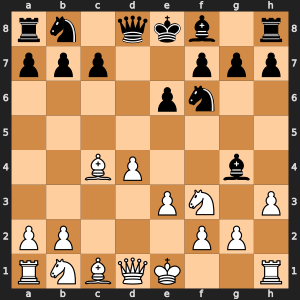

In [520]:
game = chess.pgn.read_game(pgn)
print(game.headers)
board = game.board()
for idx, m in enumerate(game.mainline_moves()):
  board.push(m)
  if idx == 10:
    f1 = board.copy()
  if idx == 70:
    f2 = board.copy()
#f2 = board.copy()
SVG(chess.svg.board(f1, size=300))

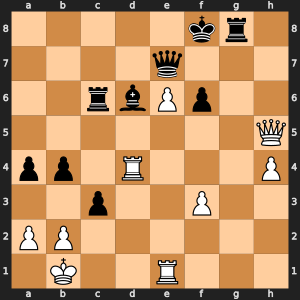

In [521]:
SVG(chess.svg.board(f2, size=300))

In [522]:
from parse_game import board_state
ff1 = torch.tensor(board_state(f1), dtype=torch.float).unsqueeze(-2)
ff2 = torch.tensor(board_state(f2), dtype=torch.float).unsqueeze(-2)
dp.eval()
dp(ff1, ff2)

tensor([[    0.00000,     1.00000]], grad_fn=<SoftmaxBackward0>)